# Импорт библиотек

In [15]:
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

import albumentations as A

import zipfile
import dotenv

from dotenv import dotenv_values

from PIL import Image
from torchvision.transforms import ToTensor

from colorize_model import ColorizationModel
import utils


# Настройки

In [16]:
# загрузить параметры
settings = {
    **dotenv_values("settings")
}

SEED = int(settings['SEED'])
IMAGE_SIZE = int(settings['IMAGE_SIZE'])

root_folder = Path.cwd()
print(f'root_folder: {root_folder}')

data_folder = Path(root_folder, settings['DATA_SUBFOLDER'])
print(f'dataset_folder: {data_folder}')
if not Path.is_dir(data_folder):
    data_folder.mkdir()

models_folder = Path(root_folder, settings['MODELS_SUBFOLDER'])
print(f'models_folder: {models_folder}')
if not Path.is_dir(models_folder):
    models_folder.mkdir()

output_folder = Path(root_folder, settings['OUTPUT_SUBFOLDER'])
print(f'output_folder: {output_folder}')
if not Path.is_dir(output_folder):
    output_folder.mkdir()

DATASET_ZIP_FILENAME_01 = settings['DATASET_ZIP_FILENAME_01']
GRAY_SUBFOLDER_01 = settings['GRAY_SUBFOLDER_01']
COLOR_SUBFOLDER_01 = settings['COLOR_SUBFOLDER_01']

dataset_zip_01 = Path(data_folder, f'{DATASET_ZIP_FILENAME_01}.zip')
extracted_dataset_folder_01 = Path(data_folder, DATASET_ZIP_FILENAME_01)

gray_folder_01 = Path(extracted_dataset_folder_01, GRAY_SUBFOLDER_01)
color_folder_01 = Path(extracted_dataset_folder_01, COLOR_SUBFOLDER_01)
print(f'gray_folder_01: {gray_folder_01}')
print(f'color_folder_01: {color_folder_01}')    


DATASET_ZIP_FILENAME_02 = settings['DATASET_ZIP_FILENAME_02']
GRAY_SUBFOLDER_02 = settings['GRAY_SUBFOLDER_02']
COLOR_SUBFOLDER_02 = settings['COLOR_SUBFOLDER_02']

dataset_zip_02 = Path(data_folder, f'{DATASET_ZIP_FILENAME_02}.zip')
extracted_dataset_folder_02 = Path(data_folder, DATASET_ZIP_FILENAME_02)

gray_folder_02 = Path(extracted_dataset_folder_02, GRAY_SUBFOLDER_02)
color_folder_02 = Path(extracted_dataset_folder_02, COLOR_SUBFOLDER_02)
print(f'gray_folder_02: {gray_folder_02}')
print(f'color_folder_02: {color_folder_02}')    

root_folder: /home/igel2/Projects/ml_final
dataset_folder: /home/igel2/Projects/ml_final/data
models_folder: /home/igel2/Projects/ml_final/models
output_folder: /home/igel2/Projects/ml_final/outputs
gray_folder_01: /home/igel2/Projects/ml_final/data/landscape-image-colorization/landscape Images/gray
color_folder_01: /home/igel2/Projects/ml_final/data/landscape-image-colorization/landscape Images/color
gray_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/train_black
color_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/train_color


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device={device}')
seed_worker = utils.set_seed(SEED)

device=cuda


In [18]:
# True - меньше эпох и только небольшая часть выборки
DEBUG_MODE = False

if DEBUG_MODE:
    num_epochs = 7
    part_of_dataset = 0.3
else:
    num_epochs = 50

num_workers = 4
batch_size = 16
test_size=0.2


# Подготовка набора картинок

Загрузим два разных датасета и обучать будем на миксе двух датасетов. Так модель получилась лучше

In [19]:
if not dataset_zip_01.exists():
    !kaggle datasets download theblackmamba31/landscape-image-colorization -p "data"

if not extracted_dataset_folder_01.exists():
    with zipfile.ZipFile(dataset_zip_01, 'r') as clr_dataset_zip:
        clr_dataset_zip.extractall(extracted_dataset_folder_01)

if not dataset_zip_02.exists():
    !kaggle datasets download aayush9753/image-colorization-dataset -p "data"

    with zipfile.ZipFile(dataset_zip_02, 'r') as clr_dataset_zip:
        clr_dataset_zip.extractall(extracted_dataset_folder_02)


In [20]:
# соберем микс из двух датасетов и подели на тренировочную и валидационную выборки
# Учтем отладочный режим - если он включен, то используем только часть датасета, размер которой задан в part_of_dataset

color_files_train = []
gray_files_train = []
color_files_val = []
gray_files_val = []

color_files_01 = sorted(color_folder_01.glob("*.jpg"), key=lambda x: int(x.stem))
gray_files_01 = sorted(gray_folder_01.glob("*.jpg"), key=lambda x: int(x.stem))
if DEBUG_MODE:
    color_files_01 = color_files_01[:int(len(color_files_01) * part_of_dataset)]
    gray_files_01 = gray_files_01[:int(len(gray_files_01) * part_of_dataset)]
idx_01 = [i for i in range(len(color_files_01))]
train_idx_01, val_idx_01 = train_test_split(idx_01, test_size=test_size, random_state=SEED)
for i in train_idx_01:
    color_files_train.append(color_files_01[i])
    gray_files_train.append(gray_files_01[i])
for i in val_idx_01:
    color_files_val.append(color_files_01[i])
    gray_files_val.append(gray_files_01[i])    

color_files_02 = sorted(color_folder_02.glob("*.jpg"), key=lambda x: int(x.stem.replace('image', '')))
gray_files_02 = sorted(gray_folder_02.glob("*.jpg"), key=lambda x: int(x.stem.replace('image', '')))
if DEBUG_MODE:
    color_files_02 = color_files_02[:int(len(color_files_02) * part_of_dataset)]
    gray_files_02 = gray_files_02[:int(len(gray_files_02) * part_of_dataset)]
idx_02 = [i for i in range(len(color_files_02))]
train_idx_02, val_idx_02 = train_test_split(idx_02, test_size=test_size, random_state=SEED)
for i in train_idx_02:
    color_files_train.append(color_files_02[i])
    gray_files_train.append(gray_files_02[i])
for i in val_idx_02:
    color_files_val.append(color_files_02[i])
    gray_files_val.append(gray_files_02[i])

In [21]:
print(f'color_files_train: {np.shape(color_files_train)}')
print(f'grey_files_train: {np.shape(gray_files_train)}')
print(f'color_files_test: {np.shape(color_files_val)}')
print(f'grey_files_test: {np.shape(gray_files_val)}')

color_files_train: (9703,)
grey_files_train: (9703,)
color_files_test: (2426,)
grey_files_test: (2426,)


# Контроль структуры данных

In [22]:
# проверить наличие каталогов
assert Path(extracted_dataset_folder_01).exists()
assert Path(gray_folder_01).exists()
assert Path(color_folder_01).exists()
assert Path(gray_folder_02).exists()
assert Path(color_folder_02).exists()
assert Path(models_folder).exists()
assert Path(output_folder).exists()


# Dataset + DataLoader

In [23]:
class ColorizationDataset(Dataset):
    def __init__(self, color_files, image_size=(400, 400), augment=True):
        self.color_files = color_files
        self.image_size = image_size
        self.augment = augment

        # Аугментации
        self.spatial_aug = A.Compose([
            A.RandomResizedCrop(size=image_size, scale=(0.95, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        ], additional_targets={'image0': 'image'})

        self.final_transform = A.Compose([
            A.Resize(image_size[0], image_size[1]),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Нормализация[-1, 1]
        ])

    def __len__(self):
        return len(self.color_files)

    def __getitem__(self, idx):
        color_path = self.color_files[idx]
        color_image = Image.open(color_path).convert("RGB")
        color_image = np.array(color_image)
        if self.augment:
            transformed = self.spatial_aug(image=color_image)
            color_image = transformed["image"]
        # Нормализация и преобразование в тензор
        color_image = self.final_transform(image=color_image)["image"]
        L, ab = utils.RGBTensor_to_LAB(ToTensor()(color_image))
        return L, ab

# fit()


In [24]:
def fit(model, train_loader, val_loader, num_epochs, device, criterion):

    optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_loss_by_epoch = []
    val_loss_by_epoch = []

    best_train_loss = float('inf')  # Лучший loss по train-criterion
    best_val_loss = float('inf')  # Лучший loss по loss-criterion

    for epoch in range(num_epochs):
        # Training
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        train_losses = []
        for input_L, target_ab in loop:
            input_L = input_L.to(device)
            target_ab = target_ab.to(device)

            pred_ab = model(input_L)
            loss = criterion(pred_ab, target_ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item = loss.item()

            train_losses.append(loss_item)

            loop.set_postfix(loss=loss_item)

        avg_train_loss = np.mean(train_losses)
        train_loss_by_epoch.append(avg_train_loss)

        # Validation
        model.eval()
        val_losses = []
        with torch.inference_mode():
            val_bar = tqdm(val_loader, desc="Validation")
            for input_L, target_ab in val_bar:
                input_L = input_L.to(device)
                target_ab = target_ab.to(device)

                pred_ab = model(input_L)
                loss = criterion(pred_ab, target_ab)
                loss_item = loss.item()

                val_losses.append(loss_item)
                val_bar.set_postfix(loss=loss_item)
        avg_val_loss = np.mean(val_losses)
        val_loss_by_epoch.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train G Loss: {avg_train_loss:.4f}, Train D Loss: {avg_train_loss:.4f} | "
              f"Val G Loss: {avg_val_loss:.4f}, Val D Loss: {avg_val_loss:.4f}")

        # LR Scheduling
        scheduler.step(avg_val_loss)

        # === Сохранение лучшей модели ===
        if avg_val_loss < best_val_loss:
            best_val_disc_loss = avg_val_loss
            fn = utils.model_filename(model, models_folder, "best_val")
            torch.save(model.state_dict().copy(), fn)
            print(f"Новая лучшая по Validation Discriminator Loss ({best_val_disc_loss:.6f}) модель сохранена в {fn}.")
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            fn = utils.model_filename(model, models_folder, "best_train")
            torch.save(model.state_dict().copy(), fn)
            print(f"Новая лучшая по Train Discriminator Loss ({best_train_loss:.6f}) модель сохранена в {fn}.")

        print("")

        # === Сохранение чекпоинтов ===
        torch.save(model.state_dict(), utils.model_filename(model, models_folder, f'_epoch{epoch+1}'))

    return model, train_loss_by_epoch, val_loss_by_epoch

# Обучение

In [25]:
train_dataset = ColorizationDataset(color_files_train, augment=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, 
                                           num_workers=num_workers, worker_init_fn=seed_worker)

val_dataset = ColorizationDataset(color_files_val, augment=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, 
                                           num_workers=num_workers, worker_init_fn=seed_worker)

/home/igel2/anaconda3/envs/mlgpu/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [26]:
model = ColorizationModel().to(device)
criterion = nn.MSELoss()

fit_result = fit(model, train_loader, val_loader, num_epochs, device, criterion)
_, train_loss_by_epoch, val_loss_by_epoch = fit_result

Validation: 100%|██████████| 152/152 [00:21<00:00,  6.96it/s, loss=0.0191]


Epoch 1/50 | Train G Loss: 0.0279, Train D Loss: 0.0279 | Val G Loss: 0.0274, Val D Loss: 0.0274
Новая лучшая по Validation Discriminator Loss (0.027405) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.027895) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.62it/s, loss=0.0218]


Epoch 2/50 | Train G Loss: 0.0243, Train D Loss: 0.0243 | Val G Loss: 0.0283, Val D Loss: 0.0283
Новая лучшая по Validation Discriminator Loss (0.028343) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.024285) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  7.02it/s, loss=0.0347]


Epoch 3/50 | Train G Loss: 0.0227, Train D Loss: 0.0227 | Val G Loss: 0.0246, Val D Loss: 0.0246
Новая лучшая по Validation Discriminator Loss (0.024597) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.022700) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.96it/s, loss=0.0253]


Epoch 4/50 | Train G Loss: 0.0214, Train D Loss: 0.0214 | Val G Loss: 0.0247, Val D Loss: 0.0247
Новая лучшая по Validation Discriminator Loss (0.024694) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.021393) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:23<00:00,  6.58it/s, loss=0.0375]


Epoch 5/50 | Train G Loss: 0.0197, Train D Loss: 0.0197 | Val G Loss: 0.0234, Val D Loss: 0.0234
Новая лучшая по Validation Discriminator Loss (0.023439) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.019742) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.84it/s, loss=0.0233]


Epoch 6/50 | Train G Loss: 0.0187, Train D Loss: 0.0187 | Val G Loss: 0.0238, Val D Loss: 0.0238
Новая лучшая по Validation Discriminator Loss (0.023756) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.018650) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.82it/s, loss=0.0226]


Epoch 7/50 | Train G Loss: 0.0176, Train D Loss: 0.0176 | Val G Loss: 0.0243, Val D Loss: 0.0243
Новая лучшая по Validation Discriminator Loss (0.024292) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.017584) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.80it/s, loss=0.0182]


Epoch 8/50 | Train G Loss: 0.0168, Train D Loss: 0.0168 | Val G Loss: 0.0231, Val D Loss: 0.0231
Новая лучшая по Validation Discriminator Loss (0.023148) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.016833) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:23<00:00,  6.60it/s, loss=0.0211]


Epoch 9/50 | Train G Loss: 0.0160, Train D Loss: 0.0160 | Val G Loss: 0.0225, Val D Loss: 0.0225
Новая лучшая по Validation Discriminator Loss (0.022504) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.015969) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.75it/s, loss=0.0377]


Epoch 10/50 | Train G Loss: 0.0152, Train D Loss: 0.0152 | Val G Loss: 0.0219, Val D Loss: 0.0219
Новая лучшая по Validation Discriminator Loss (0.021915) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.015218) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.76it/s, loss=0.0304]


Epoch 11/50 | Train G Loss: 0.0145, Train D Loss: 0.0145 | Val G Loss: 0.0215, Val D Loss: 0.0215
Новая лучшая по Validation Discriminator Loss (0.021482) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.014536) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.76it/s, loss=0.0231] 


Epoch 12/50 | Train G Loss: 0.0142, Train D Loss: 0.0142 | Val G Loss: 0.0213, Val D Loss: 0.0213
Новая лучшая по Validation Discriminator Loss (0.021305) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.014220) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.74it/s, loss=0.0207]


Epoch 13/50 | Train G Loss: 0.0135, Train D Loss: 0.0135 | Val G Loss: 0.0227, Val D Loss: 0.0227
Новая лучшая по Validation Discriminator Loss (0.022741) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.013453) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.73it/s, loss=0.0926]


Epoch 14/50 | Train G Loss: 0.0129, Train D Loss: 0.0129 | Val G Loss: 0.0224, Val D Loss: 0.0224
Новая лучшая по Validation Discriminator Loss (0.022361) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.012874) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.74it/s, loss=0.0207]


Epoch 15/50 | Train G Loss: 0.0125, Train D Loss: 0.0125 | Val G Loss: 0.0212, Val D Loss: 0.0212
Новая лучшая по Validation Discriminator Loss (0.021211) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.012487) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.74it/s, loss=0.0129] 


Epoch 16/50 | Train G Loss: 0.0120, Train D Loss: 0.0120 | Val G Loss: 0.0211, Val D Loss: 0.0211
Новая лучшая по Validation Discriminator Loss (0.021126) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.012043) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.72it/s, loss=0.0193]


Epoch 17/50 | Train G Loss: 0.0117, Train D Loss: 0.0117 | Val G Loss: 0.0217, Val D Loss: 0.0217
Новая лучшая по Validation Discriminator Loss (0.021703) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.011682) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.74it/s, loss=0.0297]


Epoch 18/50 | Train G Loss: 0.0112, Train D Loss: 0.0112 | Val G Loss: 0.0224, Val D Loss: 0.0224
Новая лучшая по Validation Discriminator Loss (0.022435) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.011248) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:23<00:00,  6.50it/s, loss=0.0221]


Epoch 19/50 | Train G Loss: 0.0112, Train D Loss: 0.0112 | Val G Loss: 0.0234, Val D Loss: 0.0234
Новая лучшая по Validation Discriminator Loss (0.023408) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.011156) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0325]


Epoch 20/50 | Train G Loss: 0.0107, Train D Loss: 0.0107 | Val G Loss: 0.0230, Val D Loss: 0.0230
Новая лучшая по Validation Discriminator Loss (0.023008) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.010719) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0215]


Epoch 21/50 | Train G Loss: 0.0097, Train D Loss: 0.0097 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019872) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.009652) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0188] 


Epoch 22/50 | Train G Loss: 0.0092, Train D Loss: 0.0092 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019891) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.009151) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0166] 


Epoch 23/50 | Train G Loss: 0.0089, Train D Loss: 0.0089 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019855) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008927) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.93it/s, loss=0.0165]


Epoch 24/50 | Train G Loss: 0.0087, Train D Loss: 0.0087 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019863) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008731) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0187]


Epoch 25/50 | Train G Loss: 0.0086, Train D Loss: 0.0086 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019872) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008617) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.87it/s, loss=0.0283]


Epoch 26/50 | Train G Loss: 0.0085, Train D Loss: 0.0085 | Val G Loss: 0.0200, Val D Loss: 0.0200
Новая лучшая по Validation Discriminator Loss (0.020025) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008522) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.85it/s, loss=0.0397]


Epoch 27/50 | Train G Loss: 0.0084, Train D Loss: 0.0084 | Val G Loss: 0.0198, Val D Loss: 0.0198
Новая лучшая по Validation Discriminator Loss (0.019839) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008382) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.88it/s, loss=0.0165] 


Epoch 28/50 | Train G Loss: 0.0083, Train D Loss: 0.0083 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019869) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008302) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0196]


Epoch 29/50 | Train G Loss: 0.0082, Train D Loss: 0.0082 | Val G Loss: 0.0198, Val D Loss: 0.0198
Новая лучшая по Validation Discriminator Loss (0.019798) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008186) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.75it/s, loss=0.0373]


Epoch 30/50 | Train G Loss: 0.0081, Train D Loss: 0.0081 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019890) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008113) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.78it/s, loss=0.0164] 


Epoch 31/50 | Train G Loss: 0.0080, Train D Loss: 0.0080 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019911) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.008046) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.73it/s, loss=0.0273] 


Epoch 32/50 | Train G Loss: 0.0080, Train D Loss: 0.0080 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019915) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007955) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.87it/s, loss=0.0152]


Epoch 33/50 | Train G Loss: 0.0079, Train D Loss: 0.0079 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019913) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007886) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.79it/s, loss=0.0294]


Epoch 34/50 | Train G Loss: 0.0078, Train D Loss: 0.0078 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019896) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007784) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.87it/s, loss=0.0205]


Epoch 35/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019948) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007728) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.81it/s, loss=0.0173]


Epoch 36/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0198, Val D Loss: 0.0198
Новая лучшая по Validation Discriminator Loss (0.019819) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007709) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.88it/s, loss=0.13]   


Epoch 37/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0202, Val D Loss: 0.0202
Новая лучшая по Validation Discriminator Loss (0.020188) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.83it/s, loss=0.0172] 


Epoch 38/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019894) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007697) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.77it/s, loss=0.0172]


Epoch 39/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019879) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.89it/s, loss=0.0185]


Epoch 40/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019870) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:21<00:00,  6.92it/s, loss=0.0141]


Epoch 41/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019879) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.86it/s, loss=0.0329] 


Epoch 42/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019932) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007692) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.83it/s, loss=0.015] 


Epoch 43/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019864) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007681) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.75it/s, loss=0.00964]


Epoch 44/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019899) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.70it/s, loss=0.0185]


Epoch 45/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019867) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:23<00:00,  6.43it/s, loss=0.0229]


Epoch 46/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019929) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:23<00:00,  6.58it/s, loss=0.0157]


Epoch 47/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019942) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.73it/s, loss=0.0125]


Epoch 48/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019859) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.72it/s, loss=0.0168]


Epoch 49/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0199, Val D Loss: 0.0199
Новая лучшая по Validation Discriminator Loss (0.019921) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.



Validation: 100%|██████████| 152/152 [00:22<00:00,  6.73it/s, loss=0.0134] 


Epoch 50/50 | Train G Loss: 0.0077, Train D Loss: 0.0077 | Val G Loss: 0.0198, Val D Loss: 0.0198
Новая лучшая по Validation Discriminator Loss (0.019844) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.007674) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



# Визуализация loss-графиков 

In [27]:
def plot_losses(train_Loss, val_Loss):
    epochs = range(1, len(train_Loss) + 1)
    val_epochs = range(1, len(val_Loss) + 1)

    plt.figure(figsize=(14, 6))

    # График потерь генератора
    plt.plot(epochs, train_Loss, label='Train Loss', alpha=0.7)
    plt.plot(val_epochs, val_Loss, label='Validation Loss', alpha=0.7)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

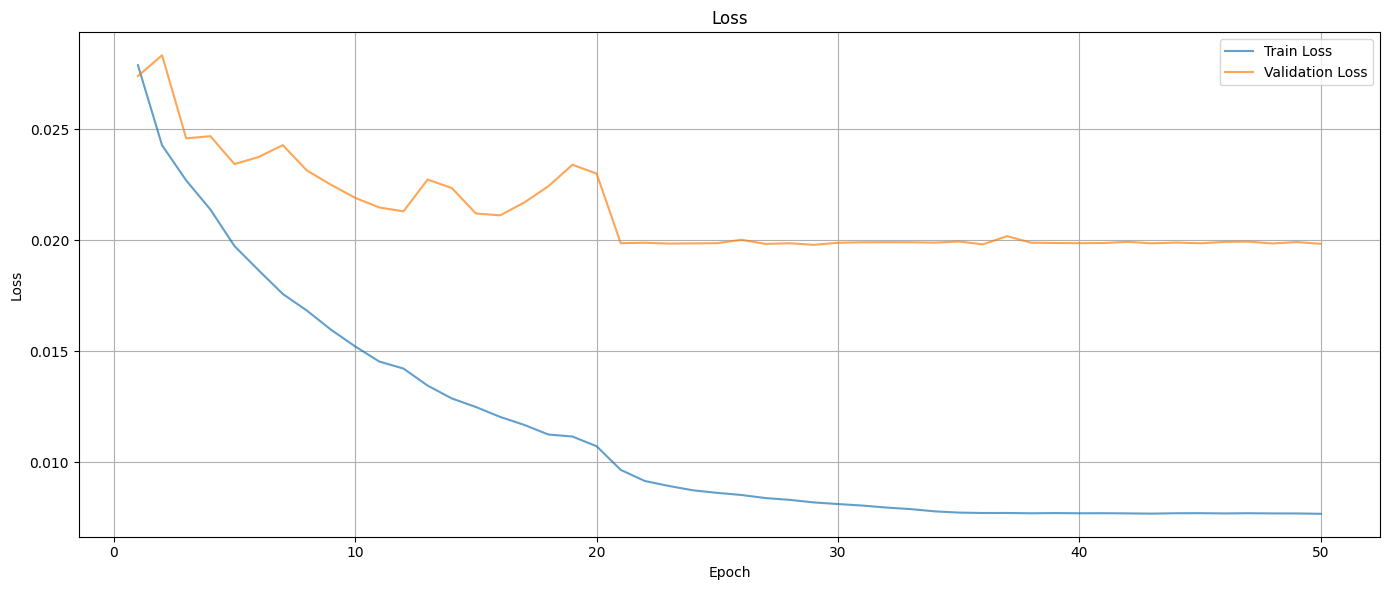

In [28]:
# Визуализация графиков
plot_losses(train_loss_by_epoch, val_loss_by_epoch)